# 2. Pré-processamento dos Dados

In [69]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from geopy.distance import geodesic

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


In [70]:

orders = pd.read_csv('../dataset/olist_orders_dataset.csv')
sellers = pd.read_csv('../dataset/olist_sellers_dataset.csv')
customers = pd.read_csv('../dataset/olist_customers_dataset.csv')
geolocation = pd.read_csv('../dataset/olist_geolocation_dataset.csv')
products = pd.read_csv('../dataset/olist_products_dataset.csv')
orders_items = pd.read_csv('../dataset/olist_order_items_dataset.csv')

# df = pd.merge(orders, customers, on='customer_id', how='left')

In [71]:

df = pd.merge(orders, orders_items, on='order_id', how='left')

geolocation['geolocation_zip_code_prefix'] = geolocation['geolocation_zip_code_prefix'].astype(str)

# Agrupar por prefixo de CEP e calcular a média de lat/lng
# Isso ajuda a ter um ponto central para cada prefixo de CEP
df_geo_agg = geolocation.groupby('geolocation_zip_code_prefix').agg(
    geo_lat=('geolocation_lat', 'mean'),
    geo_lng=('geolocation_lng', 'mean')
).reset_index()

customers['customer_zip_code_prefix'] = customers['customer_zip_code_prefix'].astype(str)
sellers['seller_zip_code_prefix'] = sellers['seller_zip_code_prefix'].astype(str)

# Merge com customers para obter customer_zip_code_prefix, city, state
df = pd.merge(df, customers[['customer_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']],
              on='customer_id', how='left')

# Merge com df_geo_agg para obter coordenadas do cliente
df = pd.merge(df, df_geo_agg,
              left_on='customer_zip_code_prefix',
              right_on='geolocation_zip_code_prefix',
              how='left')
df.rename(columns={'geo_lat': 'customer_lat', 'geo_lng': 'customer_lng'}, inplace=True)
df.drop(columns=['geolocation_zip_code_prefix'], inplace=True, errors='ignore')

# Merge com sellers para obter seller_zip_code_prefix, city, state
df = pd.merge(df, sellers[['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state']],
              on='seller_id', how='left')

# Merge com df_geo_agg para obter coordenadas do vendedor
df = pd.merge(df, df_geo_agg,
              left_on='seller_zip_code_prefix',
              right_on='geolocation_zip_code_prefix',
              how='left')
df.rename(columns={'geo_lat': 'seller_lat', 'geo_lng': 'seller_lng'}, inplace=True)
df.drop(columns=['geolocation_zip_code_prefix'], inplace=True, errors='ignore')

df = pd.merge(df, products, on='product_id', how='left')


In [72]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,seller_lat,seller_lng,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,-23.680729,-46.444238,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,595fac2a385ac33a80bd5114aec74eb8,...,-19.807681,-43.980427,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1.0,aa4383b373c6aca5d8797843e5594415,...,-21.363502,-48.229601,automotivo,46.0,232.0,1.0,420.0,24.0,19.0,21.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,...,-19.837682,-43.924053,pet_shop,59.0,468.0,3.0,450.0,30.0,10.0,20.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,1.0,65266b2da20d04dbe00c5c2d3bb7859e,...,-23.543395,-46.262086,papelaria,38.0,316.0,4.0,250.0,51.0,15.0,15.0


In [ ]:
num_imputer_median = SimpleImputer(strategy='median')
str_imputer_unknown = SimpleImputer(strategy='constant', fill_value='Unknown')

coord_cols = ['customer_lat', 'customer_lng', 'seller_lat', 'seller_lng']
for col in coord_cols:
    if col in df.columns and df[col].isnull().any():
        print(f"Imputando nulos em '{col}' com a mediana.")
        df[col] = num_imputer_median.fit_transform(df[[col]]).ravel() # .ravel() para converter de volta para 1D
    elif col not in df.columns:
        print(f"AVISO: Coluna de coordenada '{col}' não encontrada. Preenchendo com NaN e imputando.")
        df[col] = np.nan
        df[col] = num_imputer_median.fit_transform(df[[col]]).ravel()

state_city_cols = ['customer_city', 'customer_state', 'seller_city', 'seller_state']
for col in state_city_cols:
    if col in df.columns and df[col].isnull().any():
        print(f"Imputando nulos em '{col}' com 'Unknown'.")
        df[col] = str_imputer_unknown.fit_transform(df[[col]]).ravel()
    elif col not in df.columns:
        print(f"AVISO: Coluna de cidade/estado '{col}' não encontrada. Preenchendo com 'Unknown'.")
        df[col] = 'Unknown'

In [74]:
def calculate_distance_km(row):
    try:
        if all(pd.notnull(row[col]) for col in ['customer_lat', 'customer_lng', 'seller_lat', 'seller_lng']):
            # Validação básica de coordenadas
            if (-90 <= row['customer_lat'] <= 90 and -180 <= row['customer_lng'] <= 180 and
                -90 <= row['seller_lat'] <= 90 and -180 <= row['seller_lng'] <= 180):
                customer_coords = (row['customer_lat'], row['customer_lng'])
                seller_coords = (row['seller_lat'], row['seller_lng'])
                return geodesic(customer_coords, seller_coords).km
    except Exception: # Captura qualquer erro de geopy ou com os dados
        pass
    return np.nan # Retorna NaN se houver problema ou dados ausentes

df['distancia_vendedor_cliente_km'] = df.apply(calculate_distance_km, axis=1)

if df['distancia_vendedor_cliente_km'].isnull().any():
    print(f"Imputando nulos em 'distancia_vendedor_cliente_km' ({df['distancia_vendedor_cliente_km'].isnull().sum()} nulos) com a mediana.")
    df['distancia_vendedor_cliente_km'] = num_imputer_median.fit_transform(df[['distancia_vendedor_cliente_km']]).ravel()

print("Cálculo de distância concluído.")

Imputando nulos em 'distancia_vendedor_cliente_km' (1329 nulos) com a mediana.
Cálculo de distância concluído.


In [75]:
df['flag_mesmo_estado'] = np.where(df['customer_state'] == df['seller_state'], 1, 0)
df['flag_mesma_cidade'] = np.where(df['customer_city'] == df['seller_city'], 1, 0)

In [76]:
print("\nDataFrame 'df' atualizado com as novas features de localização:")
print(df[['order_id', 'distancia_vendedor_cliente_km', 'flag_mesmo_estado', 'flag_mesma_cidade', 'customer_lat', 'seller_lat']].head())


DataFrame 'df' atualizado com as novas features de localização:
                           order_id  distancia_vendedor_cliente_km  \
0  e481f51cbdc54678b7cc49136f2d6af7                      18.566632   
1  53cdb2fc8bc7dce0b6741e2150273451                     847.437333   
2  47770eb9100c2d0c44946d9cf07ec65d                     512.100044   
3  949d5b44dbf5de918fe9c16f97b45f8a                    1816.085655   
4  ad21c59c0840e6cb83a9ceb5573f8159                      29.684401   

   flag_mesmo_estado  flag_mesma_cidade  customer_lat  seller_lat  
0                  1                  0    -23.576983  -23.680729  
1                  0                  0    -12.177924  -19.807681  
2                  0                  0    -16.745150  -21.363502  
3                  0                  0     -5.774190  -19.837682  
4                  1                  0    -23.676370  -23.543395  


In [77]:
df.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 161
order_delivered_carrier_date     1968
order_delivered_customer_date    3229
order_estimated_delivery_date       0
order_item_id                     775
product_id                        775
seller_id                         775
shipping_limit_date               775
price                             775
freight_value                     775
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
customer_lat                      306
customer_lng                      306
seller_zip_code_prefix            775
seller_city                       775
seller_state                      775
seller_lat                       1028
seller_lng                       1028
product_category_name            2378
product_name_lenght              2378
product_desc

In [ ]:
# df = df[df.order_status == 'delivered'].dropna() # Remove todas as linhas que tenha qualquer atributo nulo. 

df = df[df.order_status == 'delivered'].dropna()

# formatando as colunas que tem string
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'], errors='coerce')

linhas_antes_remover_data_nula = len(df)
df.dropna(subset=['order_delivered_customer_date'], inplace=True)
linhas_apos_remover_data_nula = len(df)
print(f"Número de linhas removidas por 'order_delivered_customer_date' nulo: {linhas_antes_remover_data_nula - linhas_apos_remover_data_nula}")
print(f"Número de linhas restantes: {len(df)}")

# simpleImputer para preencher os valores ausentes com a mediana, pq mds do ceu...
# imputer = SimpleImputer(strategy='median')
# df['order_delivered_customer_date'] = imputer.fit_transform(df[['order_delivered_customer_date']])

# garantir o datetime para manipular os dados
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['delivery_time'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days

Número de linhas removidas por 'order_delivered_customer_date' nulo: 8
Número de linhas restantes: 110189


In [79]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,distancia_vendedor_cliente_km,flag_mesmo_estado,flag_mesma_cidade,delivery_time
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,268.0,4.0,500.0,19.0,8.0,13.0,18.566632,1,0,8
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,595fac2a385ac33a80bd5114aec74eb8,...,178.0,1.0,400.0,19.0,13.0,19.0,847.437333,0,0,13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1.0,aa4383b373c6aca5d8797843e5594415,...,232.0,1.0,420.0,24.0,19.0,21.0,512.100044,0,0,9
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,...,468.0,3.0,450.0,30.0,10.0,20.0,1816.085655,0,0,13
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,1.0,65266b2da20d04dbe00c5c2d3bb7859e,...,316.0,4.0,250.0,51.0,15.0,15.0,29.684401,1,0,2


(array([9.6222e+04, 1.2347e+04, 1.3370e+03, 1.8200e+02, 4.0000e+01,
        1.5000e+01, 1.8000e+01, 5.0000e+00, 1.5000e+01, 8.0000e+00]),
 array([  0. ,  20.9,  41.8,  62.7,  83.6, 104.5, 125.4, 146.3, 167.2,
        188.1, 209. ]),
 <BarContainer object of 10 artists>)

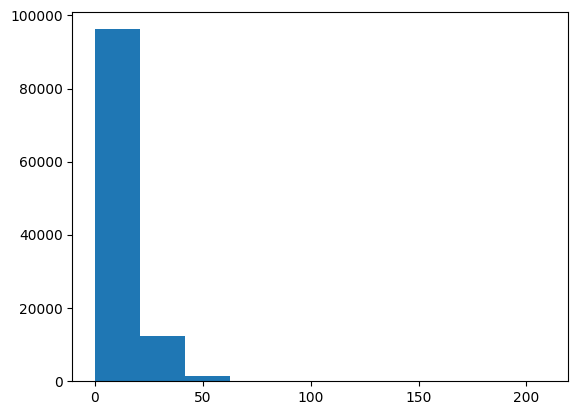

In [80]:
df.drop(df[df.delivery_time < 0].index, inplace=True)
plt.hist(df['delivery_time'])

<Axes: ylabel='delivery_time'>

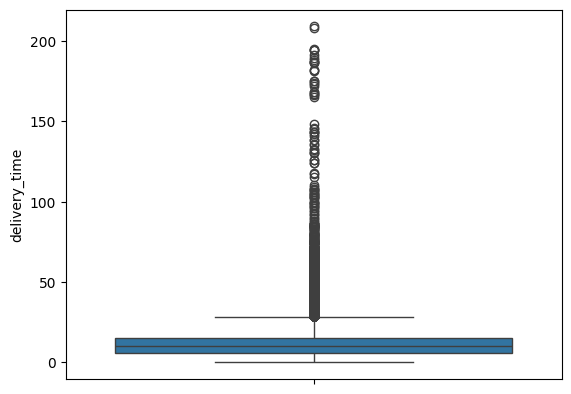

In [81]:
sns.boxplot(df['delivery_time'])

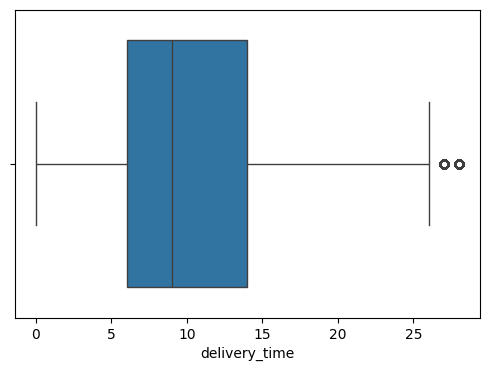

In [82]:
q1 = df['delivery_time'].quantile(0.25)
q3 = df['delivery_time'].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

df = df[(df['delivery_time'] >= lower_bound) & (df['delivery_time'] <= upper_bound)]

plt.figure(figsize=(6, 4))
sns.boxplot(x=df['delivery_time'])
plt.show()

In [83]:
# usar em caso de padronizacao para machine learning como o KNN na parte do treinamento... por agr nao tem utilidade
# scaler = StandardScaler()
# print(scaler.fit_transform(df[['delivery_time']]))
# df[['delivery_time']] = scaler.fit_transform(df[['delivery_time']])


# encoder = OneHotEncoder(sparse_output=False)
# encoded_order_status = encoder.fit_transform(df[['order_status']])
# df_encoded = pd.DataFrame(encoded_order_status, columns=encoder.get_feature_names_out(['order_status']))

# df = pd.concat([df, df_encoded], axis=1)

In [84]:
# le_state = LabelEncoder()
# df['customer_state_encoded'] = le_state.fit_transform(df['customer_state'])
# df['seller_state_encoded'] = le_state.fit_transform(df['seller_state'])

# le_category = LabelEncoder()
# df['product_category_name_encoded'] = le_category.fit_transform(df['product_category_name'])



# ----- One-Hot Encoding para customer_state -----
# Instanciar o OneHotEncoder
# handle_unknown='ignore': se uma nova categoria aparecer nos dados de teste/produção,
#                          todas as colunas OHE para essa feature serão zero, evitando erro.
# sparse_output=False: para retornar um array denso (mais fácil de converter para DataFrame)
ohe_customer_state = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Aplicar fit_transform na coluna 'customer_state'
# ohe_customer_state.fit_transform precisa de um array 2D, então usamos df[['customer_state']]
customer_state_ohe_features = ohe_customer_state.fit_transform(df[['customer_state']])

# Criar um DataFrame com as novas colunas OHE
# ohe_customer_state.get_feature_names_out(['customer_state']) cria nomes de colunas significativos
customer_state_ohe_df = pd.DataFrame(customer_state_ohe_features,
                                     columns=ohe_customer_state.get_feature_names_out(['customer_state']),
                                     index=df.index) # Mantém o índice original

# Concatenar as novas features OHE ao DataFrame original e remover a coluna original
df = pd.concat([df, customer_state_ohe_df], axis=1)
df.drop('customer_state', axis=1, inplace=True)

# ----- Repetir para seller_state -----
ohe_seller_state = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
seller_state_ohe_features = ohe_seller_state.fit_transform(df[['seller_state']])
seller_state_ohe_df = pd.DataFrame(seller_state_ohe_features,
                                   columns=ohe_seller_state.get_feature_names_out(['seller_state']),
                                   index=df.index)
df = pd.concat([df, seller_state_ohe_df], axis=1)
df.drop('seller_state', axis=1, inplace=True)

print(df['product_category_name'].nunique())

le_category = LabelEncoder()
df['product_category_name_encoded'] = le_category.fit_transform(df['product_category_name'])

print("DataFrame após One-Hot Encoding (exemplo):")
print(df.head())
print(df.columns)

73
DataFrame após One-Hot Encoding (exemplo):
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1 

In [85]:
if not os.path.exists('../dataset/dados_tratados.csv'):
    df.to_csv('../dataset/dados_tratados.csv', index=False)
else:
    print(f'Arquivo ja criado no diretorio dataset... vai la olhar!')
    pass

df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,seller_state_PI,seller_state_PR,seller_state_RJ,seller_state_RN,seller_state_RO,seller_state_RS,seller_state_SC,seller_state_SE,seller_state_SP,product_category_name_encoded
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,595fac2a385ac33a80bd5114aec74eb8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,62
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1.0,aa4383b373c6aca5d8797843e5594415,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,1.0,65266b2da20d04dbe00c5c2d3bb7859e,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,59
